In [9]:
pip install pillow

In [44]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time
import os, os.path

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for i in imgs:
        # Read in each one by one
        image = mpimg.imread(i)
        
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [45]:
# Get fishplate and non-fishplate images

# path joining version for other paths
fishplate_images = '/content/drive/My Drive/Mod1-IITR/fishplate/pos'
print("Fishplate images:")
print (len([name for name in os.listdir(fishplate_images) if os.path.isfile(os.path.join(fishplate_images, name))]))


nonfishplate_images = '/content/drive/My Drive/Mod1-IITR/fishplate/neg'
print("Non-fishplate images:")
print (len([name for name in os.listdir(nonfishplate_images) if os.path.isfile(os.path.join(nonfishplate_images, name))]))

Fishplate images:
9
Non-fishplate images:
9


Fishplate and not-fishplate sample images from the training set:


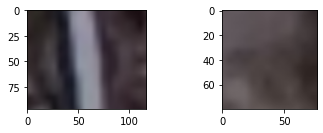

In [46]:
# Get sample images from training set
fishplate_img    = mpimg.imread('/content/drive/My Drive/Mod1-IITR/fishplate/pos/1.PNG')
not_fishplate_img = mpimg.imread('/content/drive/My Drive/Mod1-IITR/fishplate/neg/a.PNG')

# Plot sample images from training set
print("Fishplate and not-fishplate sample images from the training set:")
fig = plt.figure()
fig.add_subplot(2,2,1)
plt.imshow(fishplate_img.squeeze(), cmap="gray")
fig.add_subplot(2,2,2)
plt.imshow(not_fishplate_img.squeeze(), cmap="gray")

In [47]:
# Get Sample Images
fishplate_img = mpimg.imread('/content/drive/My Drive/Mod1-IITR/fishplate/pos/1.PNG')
not_fishplate_img = mpimg.imread('/content/drive/My Drive/Mod1-IITR/fishplate/neg/a.PNG')

# Get HOG features from images
fishplate_dst = get_hog_features(fishplate_img[:,:,2], 9, 8, 8, vis=False, feature_vec=True)
not_fishplate_dst = get_hog_features(not_fishplate_img[:,:,2], 9, 8, 8, vis=False, feature_vec=True)

# Display images next to their hog features 
fig = plt.figure()
fig.add_subplot(2,2,1)
plt.imshow(fishplate_img.squeeze(), cmap="gray")
fig.add_subplot(2,2,2)
plt.imshow(fishplate_dst.squeeze(), cmap="gray")
fig.add_subplot(2,2,3)
plt.imshow(not_fishplate_img.squeeze(), cmap="gray")
fig.add_subplot(2,2,4)
plt.imshow(not_fishplate_dst.squeeze(), cmap="gray")

TypeError: ignored

In [48]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'All' # Can be 0, 1, 2, or "ALL"

# Get features for images with fishplates
fishplate_features = extract_features(fishplate_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Get features for images without fishplates
notfishplate_features = extract_features(nonfishplate_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((fishplate_features, notfishplate_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(fishplate_features)), np.zeros(len(notfishplate_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Print feature details
print()
print('Using',orient,'orientations with',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

IsADirectoryError: ignored

In [49]:
# Create a linear SVC 
svc = LinearSVC()

# Train the SVC Classifer using the .fit() method
svc.fit(X_train, y_train)

# Check the accuracy of the SVC
print('Test Accuracy =', round(svc.score(X_test, y_test), 4))

NameError: ignored

In [50]:
def find_fishplates(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # Define array of rectangles surrounding fishplates that were detected
    rectangles = []
    
    # Normalize image
    img = img.astype(np.float32)/255
    search_img = img[ystart:ystop,:,:]

    # Apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            search_ctrans = cv2.cvtColor(search_img, cv2.COLOR_RGB2HSV)
        elif cspace == 'YUV':
            search_ctrans = cv2.cvtColor(search_img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            search_ctrans = cv2.cvtColor(search_img, cv2.COLOR_RGB2YCrCb)
    else: search_ctrans = np.copy(image)   
    
    # Rescale image if not 1.0
    if scale != 1:
        img_shape = search_ctrans.shape
        search_ctrans = cv2.resize(search_ctrans, (np.int(img_shape[1]/scale), np.int(img_shape[0]/scale)))
    
    # Select color channel for HOG 
    if hog_channel == 'ALL':
        channel_1 = search_ctrans[:,:,0]
        channel_2 = search_ctrans[:,:,1]
        channel_3 = search_ctrans[:,:,2]
    else: 
        channel_1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks
    nx_blocks = (channel_1.shape[1] // pix_per_cell)+1  #-1
    ny_blocks = (channel_1.shape[0] // pix_per_cell)+1  #-1 
    
    # Define sampling rate with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2
    nx_steps = (nx_blocks - nblocks_per_window) // cells_per_step
    ny_steps = (ny_blocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(channel_1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(channel_2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(channel_3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for x in range(nx_steps):
        for y in range(ny_steps):
            y_position = y * cells_per_step
            x_position = x * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[y_position:y_position+nblocks_per_window, x_position:x_position+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[y_position:y_position+nblocks_per_window, x_position:x_position+nblocks_per_window].ravel() 
                hog_feat3 = hog3[y_position:y_position+nblocks_per_window, x_position:x_position+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            x_left = x_position*pix_per_cell
            y_top = y_position*pix_per_cell
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                x_box_left = np.int(x_left*scale)
                y_top_draw = np.int(y_top*scale)
                window_draw = np.int(window*scale)
                rectangles.append(((x_box_left, y_top_draw+ystart),(x_box_left+window_draw,y_top_draw+window_draw+ystart)))
                
    return rectangles

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected fishplates
    rects = []
    for fishplate_number in range(1, labels[1]+1):
        # Find pixels with each fishplate_number label value
        nonzero = (labels[0] == fishplate_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rect

In [51]:
# Get test image
test_img = mpimg.imread('/content/drive/My Drive/Mod1-IITR/314_1.PNG')

# Set parameters for find_fishplates function
ystart = 400
ystop = 660
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# Get output rectangles surrounding the fishplates we found
rectangles = find_fishplates(test_img, ystart, ystop, scale, colorspace, 
                       hog_channel, svc, None, orient, pix_per_cell,
                       cell_per_block, None, None)

# Draw boxes where fishplates are located in test image
test_img_rects = draw_boxes(test_img, rectangles)

# Plot the new image
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

error: ignored

In [54]:
# Load test image
test_img = mpimg.imread('/content/drive/My Drive/Mod1-IITR/314_1.PNG')

# Create array to hold the select boxes where we found fishplates
rects = []

# Set search dimensions for layer
ystart = 400
ystop = 470
scale = 1.0

# Find rectanlges in image and add them to the list
rects.append(find_fishplates(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

# Set search dimensions for layer
ystart = 420
ystop = 480
scale = 1.0

# Find rectangles in image and add them to the list
rects.append(find_fishplates(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

# Flatten the list of lists
rectangles = [item for sublist in rects for item in sublist]
test_img_rects = draw_boxes(test_img, rectangles)

# Plot the rectangles on the image
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of potential fishplate: ', len(rectangles))

error: ignored

In [56]:
# Load test image
test_img = mpimg.imread('/content/drive/My Drive/Mod1-IITR/314_1.PNG')

# Create array to hold the select boxes where we found fishplates
rects = []

# Set search dimensions for layer
ystart = 400
ystop = 600
scale = 3.0

# Find rectangles in image and add them to the list
rects.append(find_fishplates(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

# Set search dimensions for layer
ystart = 464
ystop = 660
scale = 3.0
rects.append(find_fishplates(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

# Flatten the list of lists
rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)

# Plot the rectangles on the image
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of potential fishplates: ', len(rectangles))

error: ignored

In [57]:
# Load test image
test_img = mpimg.imread('/content/drive/My Drive/Mod1-IITR/314_1.PNG')

# Create array to hold the select boxes where we found cars
rectangles = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

# Set search dimensions for layer
ystart = 400
ystop = 464
scale = 1.0

# Find rectangles in image and add them to the list
rectangles.append(find_fishplates(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Set search dimensions for layer
ystart = 416
ystop = 480
scale = 1.0

# Find rectangles in image and add them to the list
rectangles.append(find_fishplates(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Set search dimensions for layer
ystart = 400
ystop = 496
scale = 1.5

# Find rectangles in image and add them to the list
rectangles.append(find_fishplates(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Set search dimensions for layer
ystart = 432
ystop = 528
scale = 1.5

# Find rectangles in image and add them to the list
rectangles.append(find_fishplates(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Set search dimensions for layer
ystart = 400
ystop = 528
scale = 2.0

# Find rectangles in image and add them to the list
rectangles.append(find_fishplates(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Set search dimensions for layer
ystart = 432
ystop = 560
scale = 2.0

# Find rectangles in image and add them to the list
rectangles.append(find_fishplates(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Set search dimensions for layer
ystart = 400
ystop = 596
scale = 3.5

# Find rectangles in image and add them to the list
rectangles.append(find_fishplates(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Set search dimensions for layer
ystart = 464
ystop = 660
scale = 3.5

# Find rectangles in image and add them to the list
rectangles.append(find_fishplates(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# Flatten the list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles)

# Plot the rectangles on the image
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

error: ignored

In [58]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Test heatmap on test image
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)

# Plot result
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

NameError: ignored

In [59]:
# Threshold the heat map so it only shows places with lots of heat
heatmap_img = apply_threshold(heatmap_img, 1)

# Plot the updated heatmap
plt.figure(figsize=(10,10)) 
plt.imshow(heatmap_img, cmap='hot')

# Get labels from heatmap image
labels = label(heatmap_img)

NameError: ignored

In [60]:
# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

NameError: ignored